In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline
np.random.seed(0)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut


## Generate data 

In [2]:
import numpy as np
import pickle
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

pickle.dump(X,open('dataX.pickle','wb'))
pickle.dump(y,open('dataY.pickle','wb'))

## Split the data into test and train (20%:80%).

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 101)

In [4]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(240L, 2L)
(60L, 2L)
(240L,)
(60L,)


## Build a linear classifer assuming the multiclass logistic loss and an L2 regularization for the weights only. 

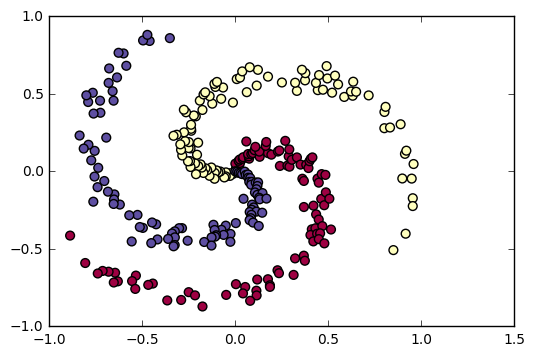

In [5]:
#Define some local varaibles
D = X.shape[1] #Number of features
K = max(y)+1 #Number of classes assuming class index starts from 0

#Plot the data
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

In [8]:
# Feedforward neural net model


# Weights initialization
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initializing values from hyperparameter
reg = 1e-3 # regularization strength

#batch SGD using manual backprop

#Batch size is equal to number of examples
num_examples = X_train.shape[0]

#Initial value for the Gradient Descent Parameter
step_size = 1e-0 #Also called learning rate

# gradient descent loop
for i in xrange(10000):
    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0.01*(np.dot(X_train,W1)+ b1), np.dot(X_train, W1) + b1) # note, Leaky ReLU activation
    scores = np.dot(hidden_layer, W2) + b2
    
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K] 
    
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y_train])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print "iteration %d: loss %f" % (i, loss)
  
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y_train] -= 1
    dscores /= num_examples
  
    # backpropate the gradient to the parameters
    
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0] #Leaky ReLU Activation
    
    # finally into W1,b1
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)
  
    # add regularization gradient contribution
    dW2 += reg * W2
    dW1 += reg * W1
  
    # perform a parameter update
    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2

    
# Post-training: evaluate t set accuracy
hidden_layer = np.maximum(0.01*(np.dot(X_train,W1) + b1), np.dot(X_train, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train))

# Post-training: evaluate test set accuracy
hidden_layer = np.maximum(0.01*(np.dot(X_test,W1) + b1), np.dot(X_test, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))

iteration 0: loss 1.098632
iteration 1000: loss 0.325854
iteration 2000: loss 0.264656
iteration 3000: loss 0.253738
iteration 4000: loss 0.253202
iteration 5000: loss 0.252914
iteration 6000: loss 0.252775
iteration 7000: loss 0.252469
iteration 8000: loss 0.252363
iteration 9000: loss 0.252629
train accuracy: 0.98
test accuracy: 0.97


## Introduce a cross validation scheme

In [11]:
kf = KFold(n_splits=10,random_state = None,shuffle = True)
kf.get_n_splits(X_train)
print(kf)  
validation_accuracy = []
cnt=0
for train_index, test_index in kf.split(X_train):
    cnt=cnt+1
    print "\n {} fold".format(cnt)
    
    X_train1, X_test1 = X_train[train_index], X_train[test_index]
    y_train1, y_test1 = y_train[train_index], y_train[test_index]
    print X_train1.shape
    print X_test1.shape
    num_examples_cv = len(y_train1)
    
    for i in xrange(15000):
        # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0.01 * (np.dot(X_train1,W1) + b1), np.dot(X_train1, W1) + b1) # Leaky ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples_cv),y_train1])
        data_loss = np.sum(corect_logprobs)/num_examples_cv
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples_cv),y_train1] -= 1
        dscores /= num_examples_cv

        # backpropate the gradient to the parameters

        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)

        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0]

        # finally into W1,b1
        dW1 = np.dot(X_train1.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW1 += reg * W1

        # perform a parameter update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        
        
    # Post-training: evaluate training set accuracy
    hidden_layer = np.maximum(0.01*(np.dot(X_train1,W1)+ b1), np.dot(X_train1, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train1))
    
    # Post-training: evaluate validation set accuracy
    hidden_layer = np.maximum(0.01*(np.dot(X_test1, W1)+ b1), np.dot(X_test1, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print 'validation accuracy: %.2f' % (np.mean(predicted_class == y_test1))
    
    validation_accuracy.append(np.mean(predicted_class == y_test1))
    
    W1_new = W1
    W2_new = W2
    b1_new = b1
    b2_new = b2
    
print "Mean of validation accuracy is {}".format(np.mean(validation_accuracy))
    
# Post-validation: evaluate test set accuracy

hidden_layer = np.maximum(0.01*(np.dot(X_test, W1_new) + b1), np.dot(X_test, W1_new) + b1_new)
scores = np.dot(hidden_layer, W2_new) + b2_new
predicted_class = np.argmax(scores, axis=1)
print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))


KFold(n_splits=10, random_state=None, shuffle=True)

 1 fold
(216L, 2L)
(24L, 2L)
iteration 0: loss 0.243814
iteration 1000: loss 0.243381
iteration 2000: loss 0.243367
iteration 3000: loss 0.243362
iteration 4000: loss 0.243363
iteration 5000: loss 0.243358
iteration 6000: loss 0.243361
iteration 7000: loss 0.243358
iteration 8000: loss 0.243357
iteration 9000: loss 0.243364
iteration 10000: loss 0.243358
iteration 11000: loss 0.243357
iteration 12000: loss 0.243362
iteration 13000: loss 0.243357
iteration 14000: loss 0.243354
train accuracy: 0.98
validation accuracy: 0.96

 2 fold
(216L, 2L)
(24L, 2L)
iteration 0: loss 0.247212
iteration 1000: loss 0.245339
iteration 2000: loss 0.245321
iteration 3000: loss 0.245320
iteration 4000: loss 0.245309
iteration 5000: loss 0.245311
iteration 6000: loss 0.245312
iteration 7000: loss 0.245304
iteration 8000: loss 0.245310
iteration 9000: loss 0.245304
iteration 10000: loss 0.245303
iteration 11000: loss 0.245298
iteration 12000: loss 0.245299

## Sensitivity of the model's performance to different learning rates and the number of gradient descent iterations

In [12]:
# Weights initialization
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initializing values from hyperparameter
reg = 1e-3 # regularization strength

#batch SGD using manual backprop

#Batch size is equal to number of examples
num_examples = X_train.shape[0]

#Initial value for the Gradient Descent Parameter
# step_size = 1e-0 #Also called learning rate

step_size = [0.000001,0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5]
d1 = {}
d2 = {}
train_accuracy = []
test_accuracy = []

for a in step_size:
    
    # gradient descent loop
    for i in xrange(10000):
        # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0.01*(np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1) #Leaky ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y_train])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples

        # backpropate the gradient to the parameters

        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)

        # backprop the Leaky ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0]

        # finally into W1,b1
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW1 += reg * W1

        # perform a parameter update
        W1 += - a * dW1
        b1 += - a * db1
        W2 += - a * dW2
        b2 += - a * db2


    # Post-training: evaluate training set accuracy
    hidden_layer = np.maximum(0.01*(np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Step size is {}".format(a)
    print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train))
    d1[a] = np.mean((predicted_class == y_train))
    
    train_accuracy.append(np.mean(predicted_class == y_train))
    

    # Post-training: evaluate test set accuracy
    hidden_layer = np.maximum(0.01*(np.dot(X_test, W1) + b1), np.dot(X_test, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Step size is {}".format(a)

    print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))
    d2[a] = np.mean((predicted_class == y_test))

    test_accuracy.append(np.mean(predicted_class == y_test))

print d1
print d2
    

iteration 0: loss 1.098541
iteration 1000: loss 1.098540
iteration 2000: loss 1.098538
iteration 3000: loss 1.098537
iteration 4000: loss 1.098535
iteration 5000: loss 1.098534
iteration 6000: loss 1.098532
iteration 7000: loss 1.098531
iteration 8000: loss 1.098529
iteration 9000: loss 1.098528
Step size is 1e-06
train accuracy: 0.43
Step size is 1e-06
test accuracy: 0.37
iteration 0: loss 1.098526
iteration 1000: loss 1.098512
iteration 2000: loss 1.098497
iteration 3000: loss 1.098483
iteration 4000: loss 1.098468
iteration 5000: loss 1.098454
iteration 6000: loss 1.098440
iteration 7000: loss 1.098426
iteration 8000: loss 1.098412
iteration 9000: loss 1.098398
Step size is 1e-05
train accuracy: 0.36
Step size is 1e-05
test accuracy: 0.23
iteration 0: loss 1.098384
iteration 1000: loss 1.098249
iteration 2000: loss 1.098121
iteration 3000: loss 1.097999
iteration 4000: loss 1.097884
iteration 5000: loss 1.097775
iteration 6000: loss 1.097672
iteration 7000: loss 1.097573
iteration 8

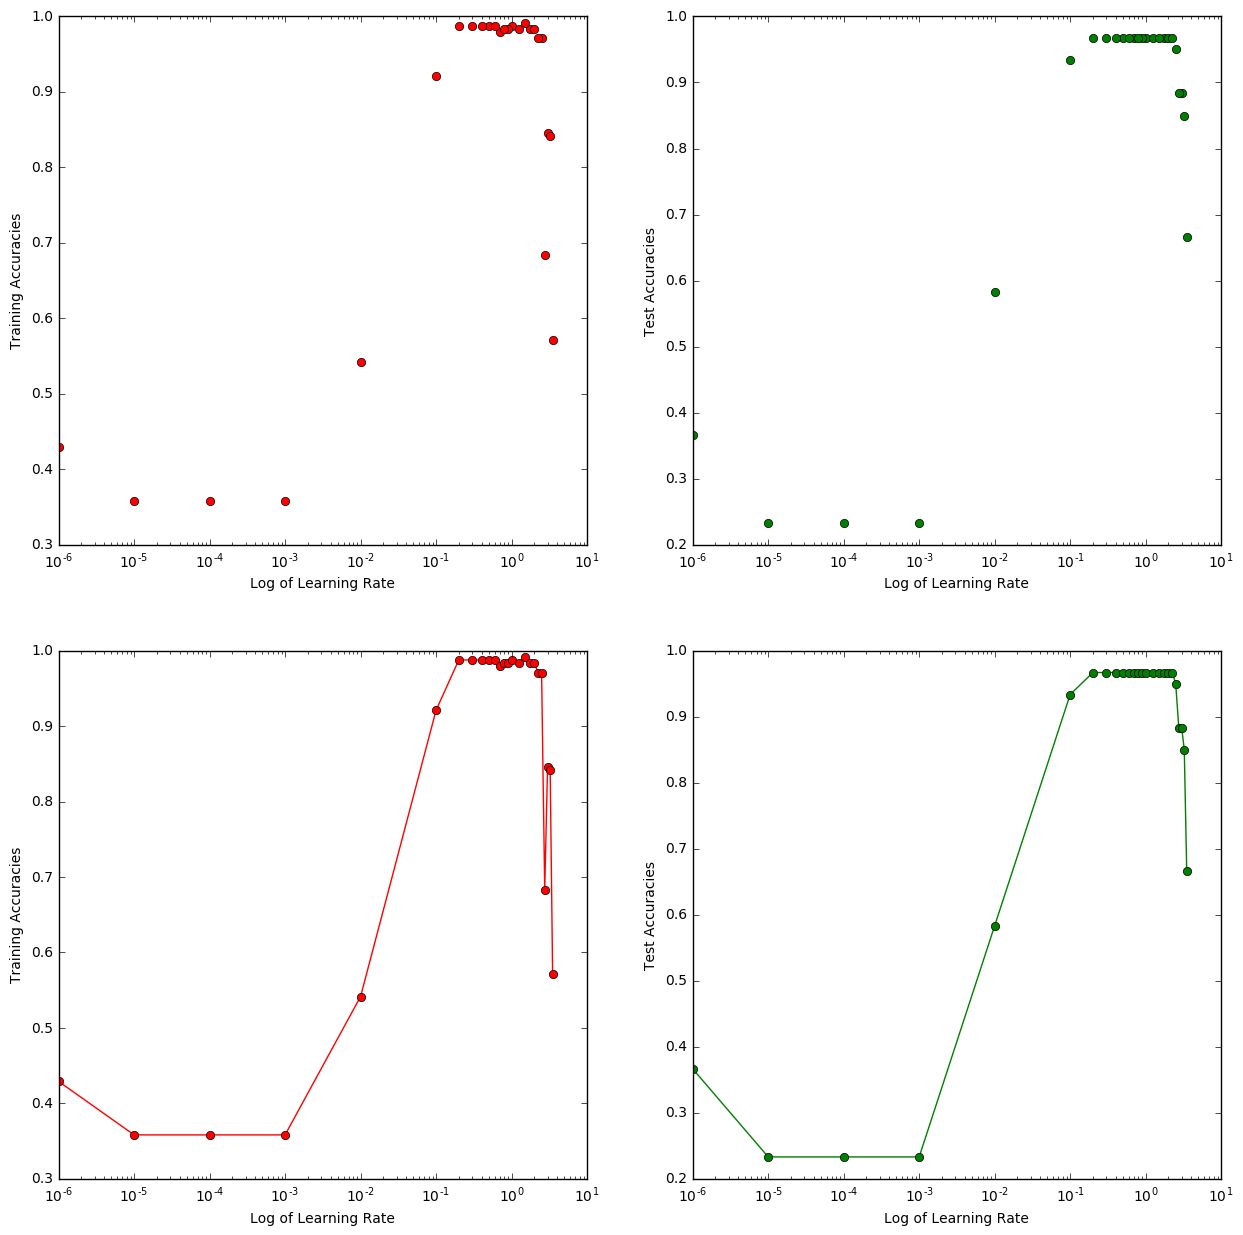

In [13]:
fig,ax = plt.subplots(2,2,figsize = (15,15))


for key,value in d1.items():
    ax[0,0].semilogx(key,value,'r',marker = 'o',linestyle = '')

for key,value in d2.items():
    ax[0,1].semilogx(key,value,'g',marker = 'o',linestyle = '')

ax[0,0].set_xlabel("Log of Learning Rate")
ax[0,0].set_ylabel("Training Accuracies")
ax[0,1].set_xlabel("Log of Learning Rate")
ax[0,1].set_ylabel("Test Accuracies")


L=[[key,value] for key,value in d1.items()]
L.sort(key= lambda x: x[0])
L=np.array(L)

ax[1,0].semilogx(L[:,0],L[:,1],'r',marker = 'o',linestyle = '-')

L=[[key,value] for key,value in d2.items()]
L.sort(key= lambda x: x[0])
L=np.array(L)

ax[1,1].semilogx(L[:,0],L[:,1],'g',marker = 'o',linestyle = '-')

ax[1,0].set_xlabel("Log of Learning Rate")
ax[1,0].set_ylabel("Training Accuracies")
ax[1,1].set_xlabel("Log of Learning Rate")
ax[1,1].set_ylabel("Test Accuracies")


In [14]:
# Weights initialization
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initializing values from hyperparameter
reg = 1e-3 # regularization strength

#batch SGD using manual backprop

#Batch size is equal to number of examples
num_examples = X_train.shape[0]

#Initial value for the Gradient Descent Parameter
step_size = 1e-0 #Also called learning rate

d3 = {}
d4 = {}

iter_list = [0,20,40,60,80,100,200,400,600,800,1000,1200,1400,1600,1800,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]

for j in iter_list:

    for i in xrange(j+1):
        
        # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0.01 * (np.dot(X_train,W1) + b1), np.dot(X_train, W1) + b1) # Leaky ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y_train])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
#         if i % 1000 == 0:
#             print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples

        # backpropate the gradient to the parameters

        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)

        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0]

        # finally into W1,b1
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW1 += reg * W1

        # perform a parameter update
        W1 += - step_size * dW1
        b1 += - step_size * db1
        W2 += - step_size * dW2
        b2 += - step_size * db2


    # Post-training: evaluate training set accuracy
    hidden_layer = np.maximum(0.01 * (np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Number of iterations are {}".format(i)
    print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train))
    d3[i] = np.mean((predicted_class == y_train))
    
    train_accuracy.append(np.mean(predicted_class == y_train))
    

    # Post-training: evaluate test set accuracy
    hidden_layer = np.maximum(0.01 * (np.dot(X_test, W1) + b1), np.dot(X_test, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Number of iterations are {}".format(i)

    print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))
    d4[i] = np.mean((predicted_class == y_test))

    test_accuracy.append(np.mean(predicted_class == y_test))

print d3
print d4



Number of iterations are 0
train accuracy: 0.36
Number of iterations are 0
test accuracy: 0.23
Number of iterations are 20
train accuracy: 0.51
Number of iterations are 20
test accuracy: 0.38
Number of iterations are 40
train accuracy: 0.51
Number of iterations are 40
test accuracy: 0.57
Number of iterations are 60
train accuracy: 0.56
Number of iterations are 60
test accuracy: 0.60
Number of iterations are 80
train accuracy: 0.67
Number of iterations are 80
test accuracy: 0.72
Number of iterations are 100
train accuracy: 0.80
Number of iterations are 100
test accuracy: 0.78
Number of iterations are 200
train accuracy: 0.91
Number of iterations are 200
test accuracy: 0.88
Number of iterations are 400
train accuracy: 0.90
Number of iterations are 400
test accuracy: 0.88
Number of iterations are 600
train accuracy: 0.95
Number of iterations are 600
test accuracy: 0.97
Number of iterations are 800
train accuracy: 0.98
Number of iterations are 800
test accuracy: 0.97
Number of iterations a

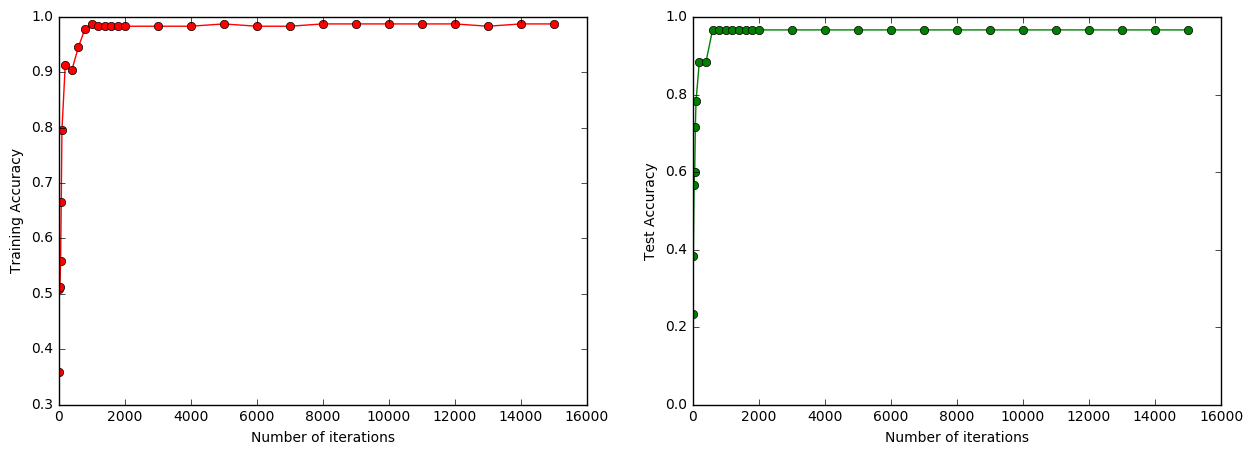

In [17]:
fig,ax = plt.subplots(1,2,figsize = (15,5))

L=[[key,value] for key,value in d3.items()]
L.sort(key= lambda x: x[0])
L=np.array(L)

# for key,value in d3.items():
#     ax[0].plot(key,value,'r',marker = 'o',linestyle = '')
ax[0].plot(L[:,0],L[:,1],'r',marker = 'o',linestyle = '-')

L=[[key,value] for key,value in d4.items()]
L.sort(key= lambda x: x[0])
L=np.array(L)


# for key,value in d4.items():
#     ax[1].plot(key,value,'g',marker = 'o',linestyle = '')
ax[1].plot(L[:,0],L[:,1],'g',marker = 'o',linestyle = '-')
ax[1].set_ylim([0,1])

ax[0].set_xlabel("Number of iterations")
ax[0].set_ylabel("Training Accuracy")
ax[1].set_xlabel("Number of iterations")
ax[1].set_ylabel("Test Accuracy")

plt.show()

## Sensitivity of the model's performance to different regularization parameter values. Find the best regularization parameter using an exhaustive search procedure.

In [18]:
# Weights initialization
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initializing values from hyperparameter
# reg = 1e-3 # regularization strength

#batch SGD using manual backprop

#Batch size is equal to number of examples
num_examples = X_train.shape[0]

#Initial value for the Gradient Descent Parameter
step_size = 1e-0 #Also called learning rate

d5 = {}
d6 = {}

p = np.arange(0,10,0.1)
for j in p:
    
    for i in xrange(15000):
        
        # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0.01 * (np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1) # Leaky ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y_train])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*j*np.sum(W1*W1) + 0.5*j*np.sum(W2*W2)
        loss = data_loss + reg_loss
#         if i % 1000 == 0:
#             print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples

        # backpropate the gradient to the parameters

        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)

        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0]

        # finally into W1,b1
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += j * W2
        dW1 += j * W1

        # perform a parameter update
        W1 += - step_size * dW1
        b1 += - step_size * db1
        W2 += - step_size * dW2
        b2 += - step_size * db2


    # Post-training: evaluate training set accuracy
    hidden_layer = np.maximum(0.01*(np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Regularization parameter is {}".format(j)
    print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train))
    d5[j] = np.mean((predicted_class == y_train))
    
    train_accuracy.append(np.mean(predicted_class == y_train))
    

    # Post-training: evaluate test set accuracy
    hidden_layer = np.maximum(0.01*(np.dot(X_test, W1) + b1), np.dot(X_test, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Regularization parameter is {}".format(j)

    print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))
    d6[j] = np.mean((predicted_class == y_test))

    test_accuracy.append(np.mean(predicted_class == y_test))

print np.mean(d5.values())
print np.mean(d6.values())



Regularization parameter is 0.0
train accuracy: 1.00
Regularization parameter is 0.0
test accuracy: 0.98
Regularization parameter is 0.1
train accuracy: 0.52
Regularization parameter is 0.1
test accuracy: 0.38
Regularization parameter is 0.2
train accuracy: 0.36
Regularization parameter is 0.2
test accuracy: 0.23
Regularization parameter is 0.3
train accuracy: 0.36
Regularization parameter is 0.3
test accuracy: 0.23
Regularization parameter is 0.4
train accuracy: 0.36
Regularization parameter is 0.4
test accuracy: 0.23
Regularization parameter is 0.5
train accuracy: 0.36
Regularization parameter is 0.5
test accuracy: 0.23
Regularization parameter is 0.6
train accuracy: 0.36
Regularization parameter is 0.6
test accuracy: 0.23
Regularization parameter is 0.7
train accuracy: 0.36
Regularization parameter is 0.7
test accuracy: 0.23
Regularization parameter is 0.8
train accuracy: 0.36
Regularization parameter is 0.8
test accuracy: 0.23
Regularization parameter is 0.9
train accuracy: 0.36
Re

C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: overflow encountered in exp
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: invalid value encountered in maximum
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: invalid value encountered in less_equal
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: RuntimeWarning: invalid value encountered in maximum
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:87: RuntimeWarning: invalid value encoun

Regularization parameter is 2.1
train accuracy: 0.33
Regularization parameter is 2.1
test accuracy: 0.33
Regularization parameter is 2.2
train accuracy: 0.33
Regularization parameter is 2.2
test accuracy: 0.33
Regularization parameter is 2.3
train accuracy: 0.33
Regularization parameter is 2.3
test accuracy: 0.33
Regularization parameter is 2.4
train accuracy: 0.33
Regularization parameter is 2.4
test accuracy: 0.33
Regularization parameter is 2.5
train accuracy: 0.33
Regularization parameter is 2.5
test accuracy: 0.33
Regularization parameter is 2.6
train accuracy: 0.33
Regularization parameter is 2.6
test accuracy: 0.33
Regularization parameter is 2.7
train accuracy: 0.33
Regularization parameter is 2.7
test accuracy: 0.33
Regularization parameter is 2.8
train accuracy: 0.33
Regularization parameter is 2.8
test accuracy: 0.33
Regularization parameter is 2.9
train accuracy: 0.33
Regularization parameter is 2.9
test accuracy: 0.33
Regularization parameter is 3.0
train accuracy: 0.33
Re

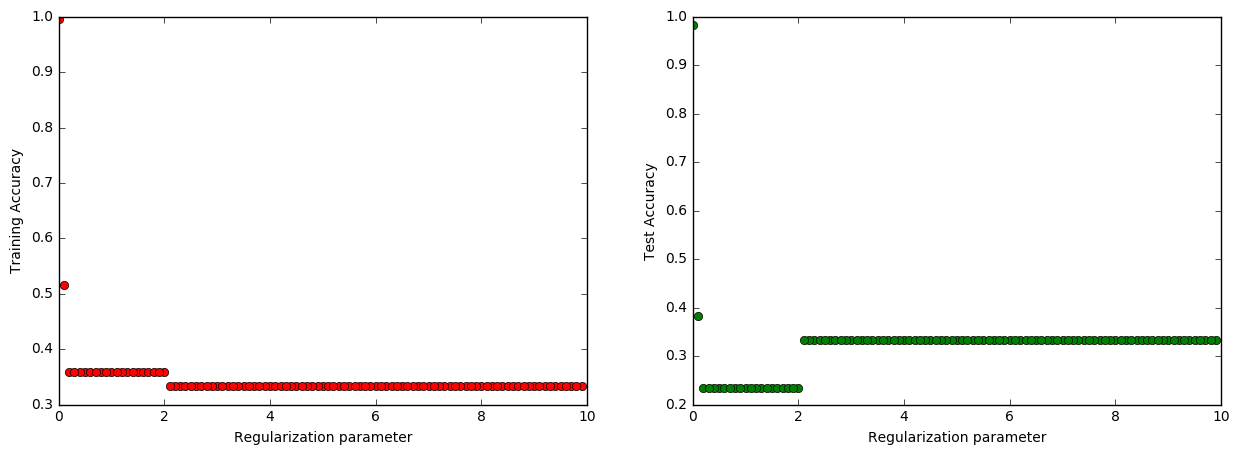

In [19]:
# range of the regularisation parameter is considered between 0 t0 10 with increments of 0.1

fig,ax = plt.subplots(1,2,figsize = (15,5))


for key,value in d5.items():
    ax[0].plot(key,value,'r',marker = 'o',linestyle = '')

for key,value in d6.items():
    ax[1].plot(key,value,'g',marker = 'o',linestyle = '')

ax[0].set_xlabel("Regularization parameter")
ax[0].set_ylabel("Training Accuracy")
ax[1].set_xlabel("Regularization parameter")
ax[1].set_ylabel("Test Accuracy")

plt.show()


what are my results if I don't multiply the regularization loss with 0.5 and the range is from 0 to 1?

In [20]:
# Weights initialization
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initializing values from hyperparameter
# reg = 1e-3 # regularization strength

#batch SGD using manual backprop

#Batch size is equal to number of examples
num_examples = X_train.shape[0]

#Initial value for the Gradient Descent Parameter
step_size = 1e-0 #Also called learning rate

d5 = {}
d6 = {}

p = np.arange(0,10,0.1)
for j in p:
    
    for i in xrange(15000):
        
        # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0.01 * (np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1) # note, ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y_train])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = j*np.sum(W1*W1) + j*np.sum(W2*W2)
        loss = data_loss + reg_loss
#         if i % 1000 == 0:
#             print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples

        # backpropate the gradient to the parameters

        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)

        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0]

        # finally into W1,b1
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += j * W2
        dW1 += j * W1

        # perform a parameter update
        W1 += - step_size * dW1
        b1 += - step_size * db1
        W2 += - step_size * dW2
        b2 += - step_size * db2


    # Post-training: evaluate training set accuracy
    hidden_layer = np.maximum(0.01 * (np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Regularization parameter is {}".format(j)
    print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train))
    d5[j] = np.mean((predicted_class == y_train))
    
    train_accuracy.append(np.mean(predicted_class == y_train))
    

    # Post-training: evaluate test set accuracy
    hidden_layer = np.maximum(0.01 * (np.dot(X_test, W1) + b1), np.dot(X_test, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Regularization parameter is {}".format(j)

    print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))
    d6[j] = np.mean((predicted_class == y_test))

    test_accuracy.append(np.mean(predicted_class == y_test))

print np.mean(d5.values())
print np.mean(d6.values())



Regularization parameter is 0.0
train accuracy: 1.00
Regularization parameter is 0.0
test accuracy: 0.98
Regularization parameter is 0.1
train accuracy: 0.52
Regularization parameter is 0.1
test accuracy: 0.38
Regularization parameter is 0.2
train accuracy: 0.36
Regularization parameter is 0.2
test accuracy: 0.23
Regularization parameter is 0.3
train accuracy: 0.36
Regularization parameter is 0.3
test accuracy: 0.23
Regularization parameter is 0.4
train accuracy: 0.36
Regularization parameter is 0.4
test accuracy: 0.23
Regularization parameter is 0.5
train accuracy: 0.36
Regularization parameter is 0.5
test accuracy: 0.23
Regularization parameter is 0.6
train accuracy: 0.36
Regularization parameter is 0.6
test accuracy: 0.23
Regularization parameter is 0.7
train accuracy: 0.36
Regularization parameter is 0.7
test accuracy: 0.23
Regularization parameter is 0.8
train accuracy: 0.36
Regularization parameter is 0.8
test accuracy: 0.23
Regularization parameter is 0.9
train accuracy: 0.36
Re

C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: overflow encountered in exp
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: invalid value encountered in maximum
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: invalid value encountered in less_equal
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: RuntimeWarning: invalid value encountered in maximum
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:87: RuntimeWarning: invalid value encoun

Regularization parameter is 2.1
train accuracy: 0.33
Regularization parameter is 2.1
test accuracy: 0.33
Regularization parameter is 2.2
train accuracy: 0.33
Regularization parameter is 2.2
test accuracy: 0.33
Regularization parameter is 2.3
train accuracy: 0.33
Regularization parameter is 2.3
test accuracy: 0.33
Regularization parameter is 2.4
train accuracy: 0.33
Regularization parameter is 2.4
test accuracy: 0.33
Regularization parameter is 2.5
train accuracy: 0.33
Regularization parameter is 2.5
test accuracy: 0.33
Regularization parameter is 2.6
train accuracy: 0.33
Regularization parameter is 2.6
test accuracy: 0.33
Regularization parameter is 2.7
train accuracy: 0.33
Regularization parameter is 2.7
test accuracy: 0.33
Regularization parameter is 2.8
train accuracy: 0.33
Regularization parameter is 2.8
test accuracy: 0.33
Regularization parameter is 2.9
train accuracy: 0.33
Regularization parameter is 2.9
test accuracy: 0.33
Regularization parameter is 3.0
train accuracy: 0.33
Re

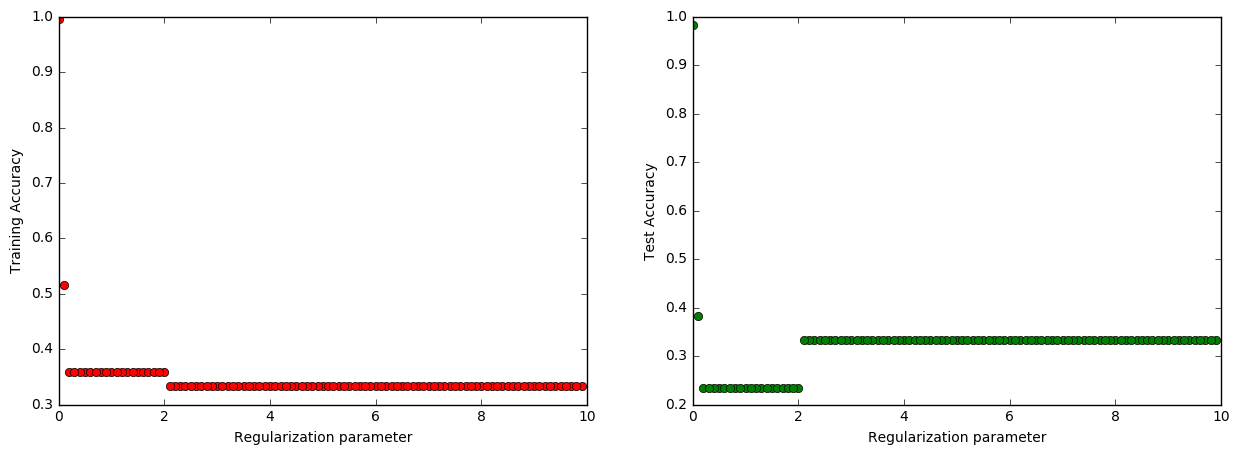

In [21]:
# range of the regularisation parameter is considered between 0 t0 1 with increments of 0.1 and the regularization loss is 
#not multiplied by 0.5

fig,ax = plt.subplots(1,2,figsize = (15,5))


for key,value in d5.items():
    ax[0].plot(key,value,'r',marker = 'o',linestyle = '')

for key,value in d6.items():
    ax[1].plot(key,value,'g',marker = 'o',linestyle = '')

ax[0].set_xlabel("Regularization parameter")
ax[0].set_ylabel("Training Accuracy")
ax[1].set_xlabel("Regularization parameter")
ax[1].set_ylabel("Test Accuracy")

plt.show()

In [22]:
# Weights initialization
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initializing values from hyperparameter
# reg = 1e-3 # regularization strength

#batch SGD using manual backprop

#Batch size is equal to number of examples
num_examples = X_train.shape[0]

#Initial value for the Gradient Descent Parameter
step_size = 1e-0 #Also called learning rate

d5 = {}
d6 = {}

p = np.arange(1e-4,1,1e-2)
for j in p:
    
    for i in xrange(15000):
        
        # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0.01 * (np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1) # note, ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y_train])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = j*np.sum(W1*W1) + j*np.sum(W2*W2)
        loss = data_loss + reg_loss
#         if i % 1000 == 0:
#             print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples

        # backpropate the gradient to the parameters

        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)

        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0]

        # finally into W1,b1
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += j * W2
        dW1 += j * W1

        # perform a parameter update
        W1 += - step_size * dW1
        b1 += - step_size * db1
        W2 += - step_size * dW2
        b2 += - step_size * db2


    # Post-training: evaluate training set accuracy
    hidden_layer = np.maximum(0.01 * (np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Regularization parameter is {}".format(j)
    print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train))
    d5[j] = np.mean((predicted_class == y_train))
    
    train_accuracy.append(np.mean(predicted_class == y_train))
    

    # Post-training: evaluate test set accuracy
    hidden_layer = np.maximum(0.01 * (np.dot(X_test, W1) + b1), np.dot(X_test, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print "Regularization parameter is {}".format(j)

    print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))
    d6[j] = np.mean((predicted_class == y_test))

    test_accuracy.append(np.mean(predicted_class == y_test))

print np.mean(d5.values())
print np.mean(d6.values())



Regularization parameter is 0.0001
train accuracy: 1.00
Regularization parameter is 0.0001
test accuracy: 0.98
Regularization parameter is 0.0101
train accuracy: 0.79
Regularization parameter is 0.0101
test accuracy: 0.75
Regularization parameter is 0.0201
train accuracy: 0.55
Regularization parameter is 0.0201
test accuracy: 0.60
Regularization parameter is 0.0301
train accuracy: 0.51
Regularization parameter is 0.0301
test accuracy: 0.53
Regularization parameter is 0.0401
train accuracy: 0.51
Regularization parameter is 0.0401
test accuracy: 0.55
Regularization parameter is 0.0501
train accuracy: 0.53
Regularization parameter is 0.0501
test accuracy: 0.57
Regularization parameter is 0.0601
train accuracy: 0.54
Regularization parameter is 0.0601
test accuracy: 0.55
Regularization parameter is 0.0701
train accuracy: 0.56
Regularization parameter is 0.0701
test accuracy: 0.53
Regularization parameter is 0.0801
train accuracy: 0.58
Regularization parameter is 0.0801
test accuracy: 0.48
R

C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: invalid value encountered in maximum
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: invalid value encountered in less_equal
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: RuntimeWarning: invalid value encountered in maximum
C:\Users\vaish\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:87: RuntimeWarning: invalid value encountered in maximum


Regularization parameter is 0.1001
train accuracy: 0.33
Regularization parameter is 0.1001
test accuracy: 0.33
Regularization parameter is 0.1101
train accuracy: 0.33
Regularization parameter is 0.1101
test accuracy: 0.33
Regularization parameter is 0.1201
train accuracy: 0.33
Regularization parameter is 0.1201
test accuracy: 0.33
Regularization parameter is 0.1301
train accuracy: 0.33
Regularization parameter is 0.1301
test accuracy: 0.33
Regularization parameter is 0.1401
train accuracy: 0.33
Regularization parameter is 0.1401
test accuracy: 0.33
Regularization parameter is 0.1501
train accuracy: 0.33
Regularization parameter is 0.1501
test accuracy: 0.33
Regularization parameter is 0.1601
train accuracy: 0.33
Regularization parameter is 0.1601
test accuracy: 0.33
Regularization parameter is 0.1701
train accuracy: 0.33
Regularization parameter is 0.1701
test accuracy: 0.33
Regularization parameter is 0.1801
train accuracy: 0.33
Regularization parameter is 0.1801
test accuracy: 0.33
R

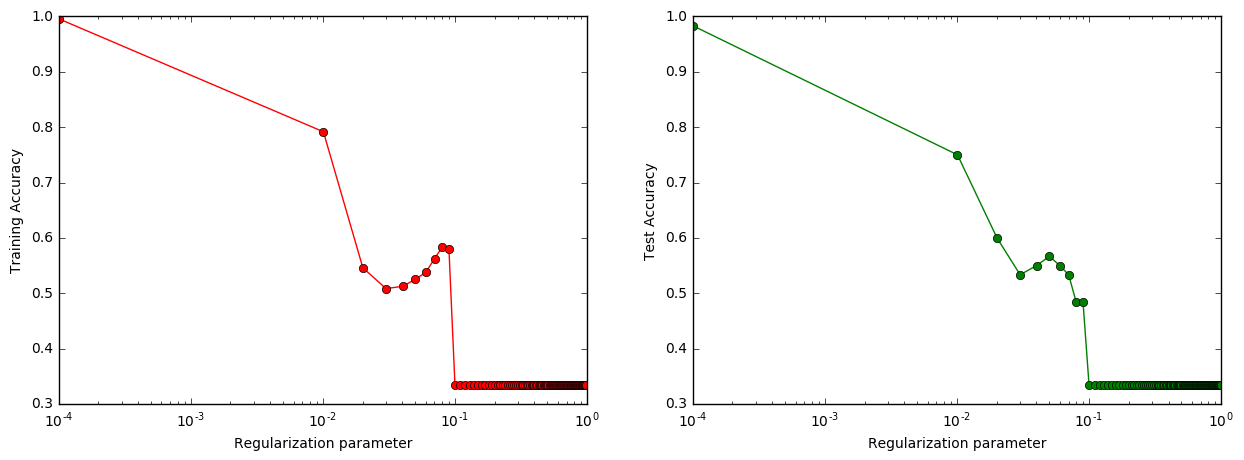

In [23]:
# range of the regularisation parameter is considered between 0 t0 10 with increments of 0.1 and the regularization loss is 
#multiplied by 0.5

fig,ax = plt.subplots(1,2,figsize = (15,5))

L=[[key,value] for key,value in d5.items()]
L.sort(key= lambda x: x[0])
L=np.array(L)
# for key,value in d5.items():
ax[0].semilogx(L[:,0],L[:,1],'r',marker = 'o',linestyle = '-')


L=[[key,value] for key,value in d6.items()]
L.sort(key= lambda x: x[0])
L=np.array(L)

# for key,value in d6.items():
ax[1].semilogx(L[:,0],L[:,1],'g',marker = 'o',linestyle = '-')

ax[0].set_xlabel("Regularization parameter")
ax[0].set_ylabel("Training Accuracy")
ax[1].set_xlabel("Regularization parameter")
ax[1].set_ylabel("Test Accuracy")


plt.show()

## sensitivity of the model's performance with respect to a different test train split (50%:50%).

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.5, random_state = 101)

In [25]:
# Feedforward neural net model


# Weights initialization
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initializing values from hyperparameter
reg = 1e-3 # regularization strength

#batch SGD using manual backprop

#Batch size is equal to number of examples
num_examples = X_train.shape[0]

#Initial value for the Gradient Descent Parameter
step_size = 1e-0 #Also called learning rate

# gradient descent loop
for i in xrange(10000):
    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0.01 * (np.dot(X_train,W1) + b1), np.dot(X_train, W1) + b1) #Leaky ReLU activation
    scores = np.dot(hidden_layer, W2) + b2
    
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
    
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y_train])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print "iteration %d: loss %f" % (i, loss)
  
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y_train] -= 1
    dscores /= num_examples
  
    # backpropate the gradient to the parameters
    
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0]
    
    # finally into W1,b1
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)
  
    # add regularization gradient contribution
    dW2 += reg * W2
    dW1 += reg * W1
  
    # perform a parameter update
    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2

    
# Post-training: evaluate t set accuracy
hidden_layer = np.maximum(0.01 * (np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train))

# Post-training: evaluate test set accuracy
hidden_layer = np.maximum(0.01 * (np.dot(X_test, W1) + b1), np.dot(X_test, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))

iteration 0: loss 1.098549
iteration 1000: loss 0.332219
iteration 2000: loss 0.286595
iteration 3000: loss 0.273460
iteration 4000: loss 0.269819
iteration 5000: loss 0.268345
iteration 6000: loss 0.266421
iteration 7000: loss 0.266233
iteration 8000: loss 0.265852
iteration 9000: loss 0.265173
train accuracy: 0.99
test accuracy: 0.97


## what happens when the number of hidden units chosen is much smaller. Similarly, what happens when the number of hidden units chosen is much higher?

In [26]:
# Feedforward neural net model


# Weights initialization
h = [10,50,100,200,500,1000]# size of hidden layer
d7 = {}
d8 = {}
for j in h:
    print "Number of hidden neurons is {}".format(j)
    W1 = 0.01 * np.random.randn(D,j)
    b1 = np.zeros((1,j))
    W2 = 0.01 * np.random.randn(j,K)
    b2 = np.zeros((1,K))

    # Initializing values from hyperparameter
    reg = 1e-3 # regularization strength

    #batch SGD using manual backprop

    #Batch size is equal to number of examples
    num_examples = X_train.shape[0]

    #Initial value for the Gradient Descent Parameter
    step_size = 1e-0 #Also called learning rate

    # gradient descent loop
    for i in xrange(10000):
        # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0.01*(np.dot(X_train, W1) + b1), np.dot(X_train, W1) + b1) # note, ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y_train])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples

        # backpropate the gradient to the parameters

        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)

        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0.01 * dhidden[hidden_layer <= 0]

        # finally into W1,b1
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW1 += reg * W1

        # perform a parameter update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2


    # Post-training: evaluate t set accuracy
    hidden_layer = np.maximum(0.01 * (np.dot(X_train,W1) + b1), np.dot(X_train, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print 'train accuracy: %.2f' % (np.mean(predicted_class == y_train))
    d7[j] = np.mean((predicted_class == y_train))


    # Post-training: evaluate test set accuracy
    hidden_layer = np.maximum(0.01 * (np.dot(X_test,W1) + b1), np.dot(X_test, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))
    d8[j] = np.mean((predicted_class == y_test))
    
print d7
print d8


Number of hidden neurons is 10
iteration 0: loss 1.098572
iteration 1000: loss 0.780101
iteration 2000: loss 0.823378
iteration 3000: loss 0.819059
iteration 4000: loss 0.770005
iteration 5000: loss 0.787758
iteration 6000: loss 0.848981
iteration 7000: loss 0.767257
iteration 8000: loss 0.806357
iteration 9000: loss 0.777360
train accuracy: 0.65
test accuracy: 0.57
Number of hidden neurons is 50
iteration 0: loss 1.098550
iteration 1000: loss 0.343227
iteration 2000: loss 0.293418
iteration 3000: loss 0.283748
iteration 4000: loss 0.280900
iteration 5000: loss 0.274301
iteration 6000: loss 0.272422
iteration 7000: loss 0.272175
iteration 8000: loss 0.270402
iteration 9000: loss 0.270216
train accuracy: 0.99
test accuracy: 0.97
Number of hidden neurons is 100
iteration 0: loss 1.098612
iteration 1000: loss 0.349994
iteration 2000: loss 0.296575
iteration 3000: loss 0.268325
iteration 4000: loss 0.263736
iteration 5000: loss 0.262229
iteration 6000: loss 0.261865
iteration 7000: loss 0.

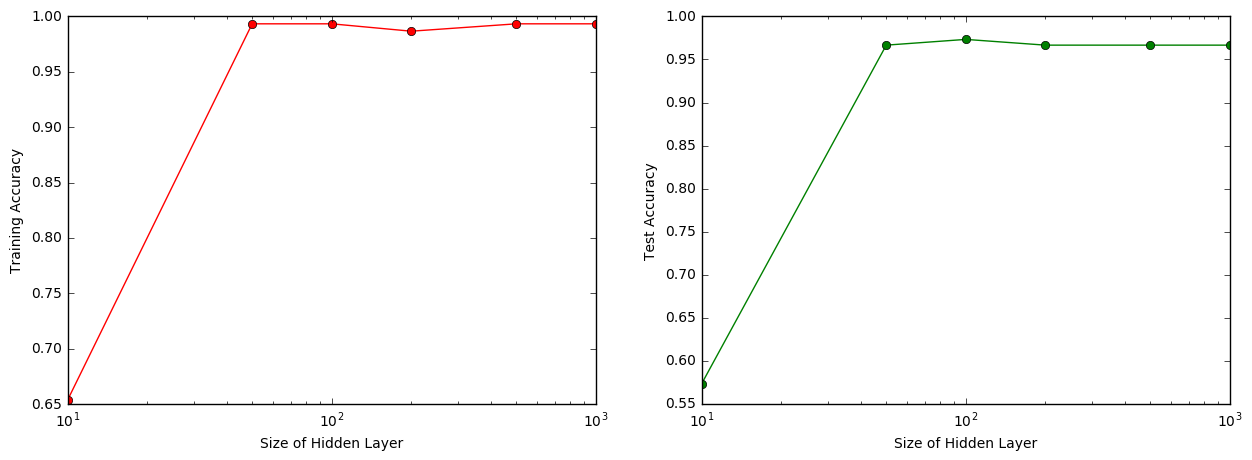

In [27]:
# range of the regularisation parameter is considered between 0 t0 10 with increments of 0.1 and the regularization loss is 
#multiplied by 0.5

fig,ax = plt.subplots(1,2,figsize = (15,5))

L=[[key,value] for key,value in d7.items()]
L.sort(key= lambda x: x[0])
L=np.array(L)
# for key,value in d5.items():
ax[0].semilogx(L[:,0],L[:,1],'r',marker = 'o',linestyle = '-')


L=[[key,value] for key,value in d8.items()]
L.sort(key= lambda x: x[0])
L=np.array(L)

# for key,value in d6.items():
ax[1].semilogx(L[:,0],L[:,1],'g',marker = 'o',linestyle = '-')

ax[0].set_xlabel("Size of Hidden Layer")
ax[0].set_ylabel("Training Accuracy")
ax[1].set_xlabel("Size of Hidden Layer")
ax[1].set_ylabel("Test Accuracy")


plt.show()